In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyvisa as visa
import time
from scipy.signal import find_peaks
from osci import TDS1002B
import os
from os import listdir
from os.path import isfile, join
from time import perf_counter


<'P'> = NHNU/T

In [2]:
rm=visa.ResourceManager()

rm.list_resources()

('USB0::0x0699::0x0363::C108011::INSTR',
 'ASRL1::INSTR',
 'ASRL2::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR')

In [3]:
osci = TDS1002B('USB0::0x0699::0x0363::C108011::INSTR')

In [141]:

# Selecciona el canal
osci._osci.write("DAT:SOU CH{0}".format(1)) 
#xze primer punto de la waveform
#xin intervalo de sampleo
#ymu factor de escala vertical
#yoff offset vertical
xze, xin, yze, ymu, yoff = osci._osci.query_ascii_values('WFMPRE:XZE?;XIN?;YZE?;YMU?;YOFF?;',separator=';')



def leer_osci(osci):

    data = (osci._osci.query_binary_values('CURV?', datatype='B',container=np.array) - yoff) * ymu + yze        
    tiempo = xze + np.arange(len(data)) * xin
    return tiempo,data

MEDICIONES

In [142]:
#MEDIMOS
#ch1 10 mv
#Trigger cambiado

nro_mediciones = 500
iteracion = 17
tiempo_integracion = 0.025 #ms
R = 50

Carpeta_Ruido = "Ruido de fondo"
Carpeta_Laser = "Mediciones con laser"
Carpeta_Resistencia = 'Mediciones con Resistencia'
Carpeta_ResistenciaPosta = 'Mediciones con Resistencia Posta'
Carpeta_Autocorrelacion = 'Autocorrelacion'

newpath = f'Clase 15-11/{Carpeta_ResistenciaPosta}/Iteración {iteracion}'
os.makedirs(newpath)

PG = 40 #Polarizador Grande
PC = 0  #Polarizador Chico
voltaje_disco = 0


for i in range(nro_mediciones):
    t0 = time.perf_counter()
    print(f'Medición nro {i}')
    # t,d = osci.read_data(channel = 1)
    t,d = leer_osci(osci)
    # t2,d2 = osci.read_data(channel = 2)
    # data = osci._osci.query_binary_values('CURV?', datatype='B', container=np.array)
    t1 = time.perf_counter()

    datos = {
    'Mediciónes' : d,
    'Tiempo' : t,
    'Tiempo de integración [ms]' : tiempo_integracion,
    "Polarizacion grande" : PG,
    "Polarizacion chica" : PC,
    "Resistencia" : R,
    'Voltaje disco': voltaje_disco
    }

    df = pd.DataFrame.from_dict(datos)
    df.to_csv(f"{newpath}/Medición nro {i}.csv", encoding = "utf-8")
    
    time.sleep(0.01)
    tf = time.perf_counter()
    print(f'Tiempo de medición: {t1 -t0}s\nTiempo de guardado: {tf-t1}s\ntiempo total de medicion: {tf-t0}s')
    

Medición nro 0
Tiempo de medición: 0.2639058999993722s
Tiempo de guardado: 0.02159159999791882s
tiempo total de medicion: 0.285497499997291s
Medición nro 1
Tiempo de medición: 0.18585299999904237s
Tiempo de guardado: 0.020842800000536954s
tiempo total de medicion: 0.20669579999957932s
Medición nro 2
Tiempo de medición: 0.18922299999758252s
Tiempo de guardado: 0.02152340000247932s
tiempo total de medicion: 0.21074640000006184s
Medición nro 3
Tiempo de medición: 0.19055460000163293s
Tiempo de guardado: 0.02079279999816208s
tiempo total de medicion: 0.21134739999979502s
Medición nro 4
Tiempo de medición: 0.19048370000018622s
Tiempo de guardado: 0.021638500002154615s
tiempo total de medicion: 0.21212220000234083s
Medición nro 5
Tiempo de medición: 0.1902101000014227s
Tiempo de guardado: 0.021177200000238372s
tiempo total de medicion: 0.21138730000166106s
Medición nro 6
Tiempo de medición: 0.3444315999986429s
Tiempo de guardado: 0.02244580000115093s
tiempo total de medicion: 0.3668773999997

Batch plot

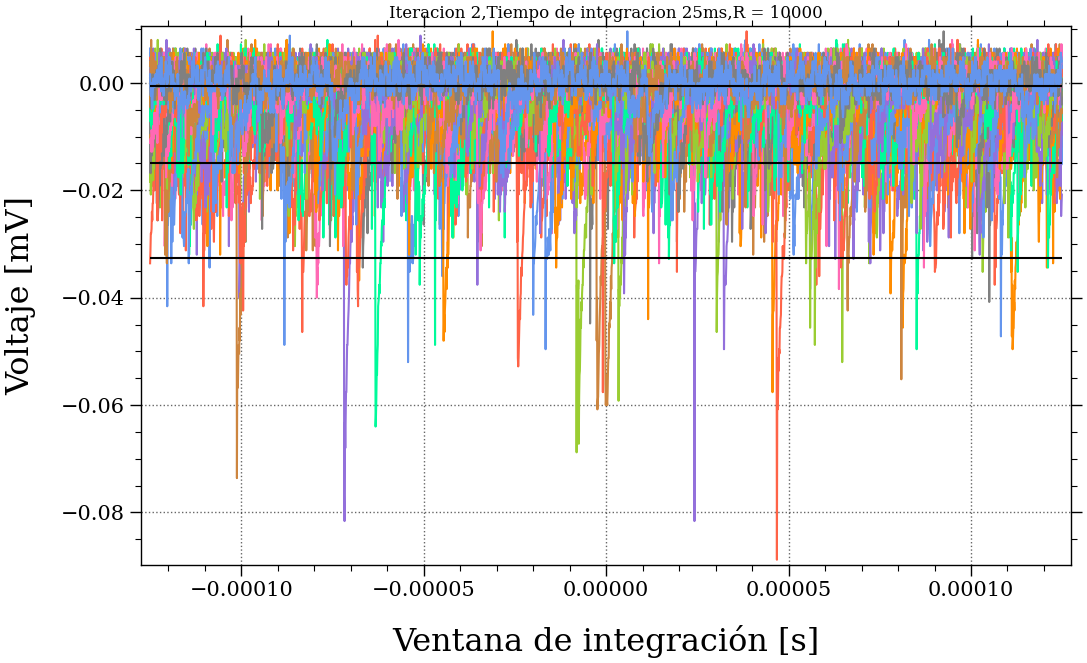

In [104]:
#PLOTEAMOS
plt.style.use('./figuras_lucio.mplstyle')

Carpeta_Ruido = "Ruido de fondo"
Carpeta_Laser = "Mediciones con laser"
Carpeta_Resistencia = 'Mediciones con Resistencia'
iteracion = 2

path = f'Clase 15-11/{Carpeta_ResistenciaPosta}/Iteración {iteracion}'
#path = f'Clase 08-11/{Carpeta_Resistencia}/Iteración {19}'

onlyfiles = [file for file in listdir(path) if isfile(join(path, file))]

fig, ax = plt.subplots()

batch_nr = 200
for file in onlyfiles:
    df = pd.read_csv(join(path, file))
    d = df['Mediciónes'].values
    t = df["Tiempo"].values
    d_mean = np.mean(d)
    d_std = np.std(d)

    ax.plot(t,d)


#xlabels = np.linspace(t[0],t[-1],10,endpoint = True)
#ax.set_xticks(xlabels*1)
#ax.set_xticklabels([f'{number:.3f}' for number in xlabels]);

ax.set_ylabel('Voltaje [mV]')
ax.set_xlabel('Ventana de integración [s]')
ax.set_title(f"Iteracion {iteracion},Tiempo de integracion {df['Tiempo de integración [ms]'].values[0]}ms,R = {R}")

ax.hlines(d_mean - 10*d_std,t[0],t[-1],color = 'black');
ax.hlines(d_mean,t[0],t[-1],color = 'black');
ax.hlines(-0.015,t[0],t[-1],color = 'black');



# fig.savefig(f'Clase 01-11/{Carpeta_Laser}/Figuras/Iteración {iteracion}.png',dpi = 800)


#Cualquier electron genera la avanlancha, no son nescesariamente osn Fotonoes

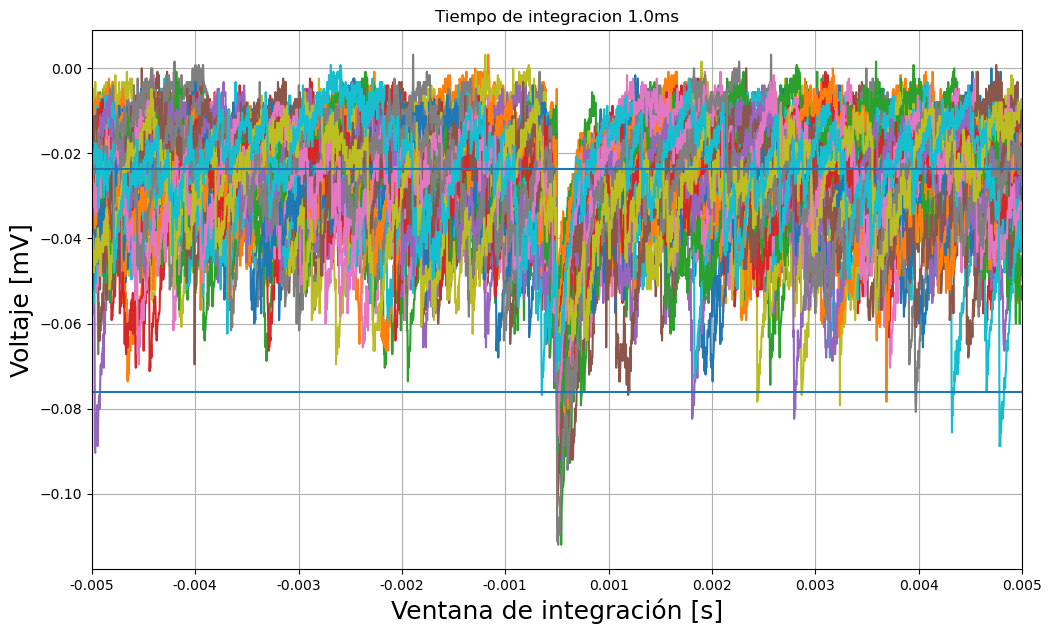

In [127]:
#PLOTEAMOS
fig, ax = plt.subplots(figsize = (12,7))
Carpeta_Ruido = "Ruido de fondo"
Carpeta_Laser = "Mediciones con laser"
batch_nr = 4
for i in range(50):
    filename = rf'C:/Users/publico/Desktop/G6L5V/Clase 01-11/{Carpeta_Laser}/iteración {batch_nr} Medición nro {i}.csv'
    df = pd.read_csv(filename)
    t = df['Datos'].values
    d = df["Tiempo"].values
    d_mean = np.mean(d)
    d_std = np.std(d)

    ax.plot(t,d)
    
t_i = df['Tiempo de integración [ms]'].values[0]
pg = df["Polarizacion grande"] = pd.Series(PG,index = [0])
pc = df["Polarizacion chica"] = pd.Series(PC,index = [0])  

ax.grid()
ax.set_xlim(t[0],t[-1])
xlabels = np.linspace(t[0],t[-1],10,endpoint = True)
ax.set_xticks(xlabels)
ax.set_xticklabels([f'{number:.3f}' for number in xlabels]);

ax.set_ylabel('Voltaje [mV]',fontsize = 18)
ax.set_xlabel('Ventana de integración [s]',fontsize = 18)
ax.set_title(f"Tiempo de integracion {df['Tiempo de integración [ms]'].values[0]}ms")

ax.hlines(d_mean - 4*d_std,t[0],t[-1])
ax.hlines(d_mean,t[0],t[-1])

Single plot

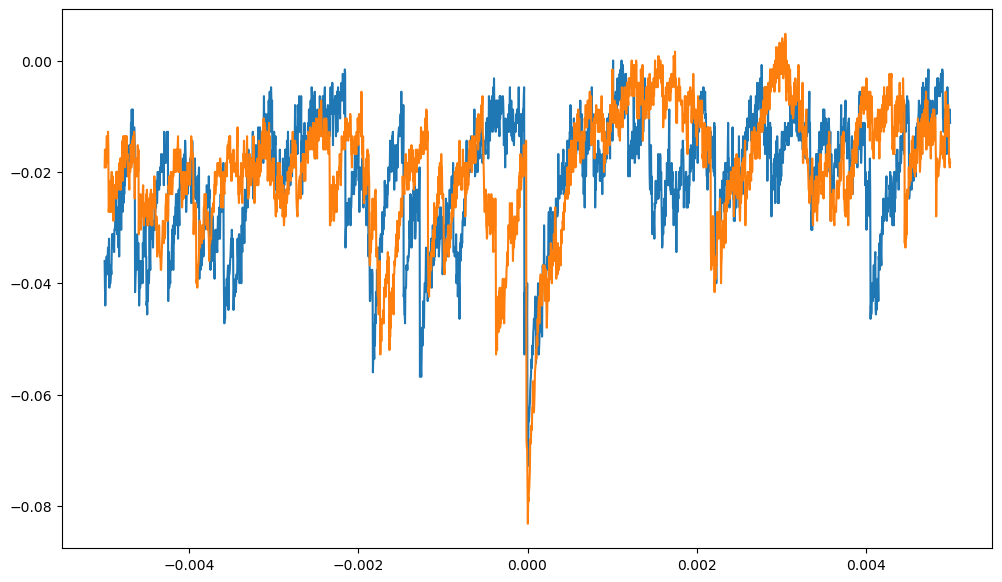

In [52]:
fig, ax = plt.subplots(figsize = (12,7))

filename1 = rf'C:/Users/publico/Desktop/G6L5V/Clase 01-11/Ruido de fondo/Medición nro {0}.csv'
filename2 = rf'C:/Users/publico/Desktop/G6L5V/Clase 01-11/Ruido de fondo/Medición nro {49}.csv'


df1 = pd.read_csv(filename1)
df2 = pd.read_csv(filename2)


t1 = df1['Datos']  
t2 = df2['Datos']

d1 = df1["Tiempo"]
d2 = df2['Tiempo']

ax.plot(t1,d1)
ax.plot(t2,d2)

In [122]:
#MEDIMOS SIN LASE
nro_mediciones = 100
iteracion = 4
tiempo_integracion = 1

PG = -40 #Polarizador Grande
PC = 0  #Polarizador Chico

data = []
tiempo = []

for i in range(nro_mediciones):
    t0 = time.time()
    print(f'Medición nro {i}')
    df = pd.DataFrame()
    t,d = osci.read_data(channel = 1)
    df['Datos'] = t 
    df["Tiempo"] = d #Tension en R2
    df['Tiempo de integración [ms]'] = pd.Series(tiempo_integracion,index = [0])
    df["Polarizacion grande"] = pd.Series(PG,index = [0])
    df["Polarizacion chica"] = pd.Series(PC,index = [0])
    df.to_csv(f"C:/Users/publico/Desktop/G6L5V/Clase 01-11/Ruido de fondo/iteración {iteracion} Medición nro {i}.csv", encoding = "utf-8")
    time.sleep(0.05)
    tf = time.time()
    print(f'Tiempo de medición: {tf -t0}s')

Medición nro 0
Tiempo de medición: 1.1563491821289062s
Medición nro 1
Tiempo de medición: 1.2885441780090332s
Medición nro 2
Tiempo de medición: 1.1580076217651367s
Medición nro 3
Tiempo de medición: 1.2904164791107178s
Medición nro 4
Tiempo de medición: 1.155785322189331s
Medición nro 5
Tiempo de medición: 1.339533805847168s
Medición nro 6
Tiempo de medición: 1.158790111541748s
Medición nro 7
Tiempo de medición: 1.3111224174499512s
Medición nro 8
Tiempo de medición: 1.1591522693634033s
Medición nro 9
Tiempo de medición: 1.2867088317871094s
Medición nro 10
Tiempo de medición: 1.154050588607788s
Medición nro 11
Tiempo de medición: 1.294651746749878s
Medición nro 12
Tiempo de medición: 1.1564476490020752s
Medición nro 13
Tiempo de medición: 1.2856128215789795s
Medición nro 14
Tiempo de medición: 1.1557979583740234s
Medición nro 15
Tiempo de medición: 1.2914013862609863s
Medición nro 16
Tiempo de medición: 1.1965134143829346s
Medición nro 17
Tiempo de medición: 1.2459540367126465s
Medició

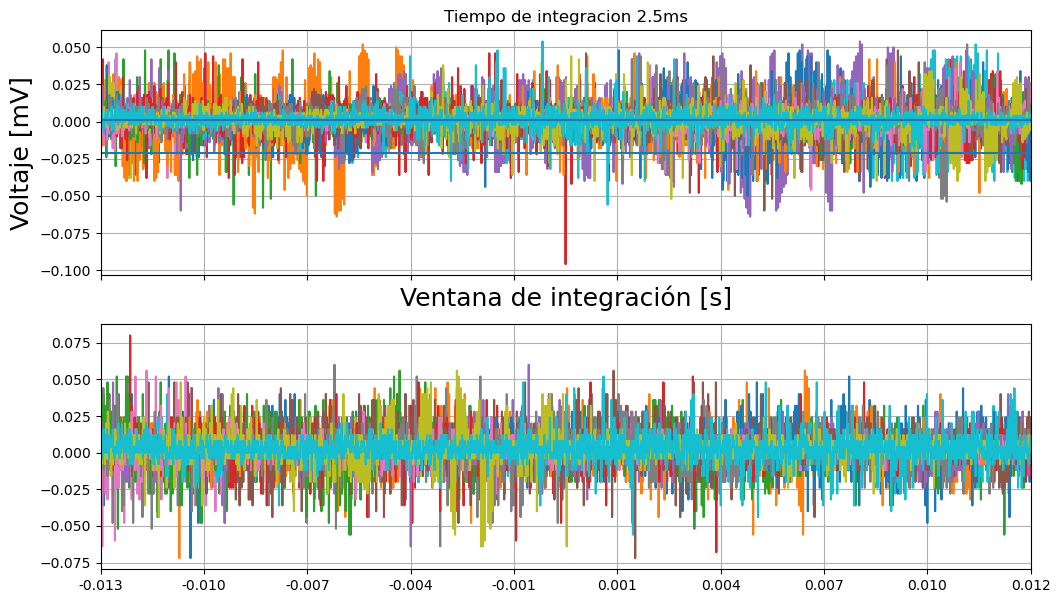

In [ ]:
#PLOTEAMOS
fig, ax = plt.subplots(2,1,figsize = (12,7),sharex=True)
batch_nr = 1
for i in range(20):
    filename = rf'C:/Users/publico/Desktop/G6L5V/Clase 01-11/{Carpeta_Resistencia}/iteración {batch_nr} Medición nro {i}.csv'
    df = pd.read_csv(filename)
    t = df['Datos'].values
    d = df["Tiempo"].values
    t2 = df['Datos Ch2'].values
    d2 = df["Tiempo Ch2"].values
    d_mean = np.mean(d)
    d_std = np.std(d)

    ax[0].plot(t,d)
    ax[1].plot(t2,d2)
    
t_i = df['Tiempo de integración [ms]'].values[0]
pg = df["Polarizacion grande"] = pd.Series(PG,index = [0])
pc = df["Polarizacion chica"] = pd.Series(PC,index = [0])

ax[0].grid()
ax[1].grid()
ax[0].set_xlim(t[0],t[-1])
xlabels = np.linspace(t[0],t[-1],10,endpoint = True)
ax[0].set_xticks(xlabels)
ax[0].set_xticklabels([f'{number:.3f}' for number in xlabels]);

ax[0].set_ylabel('Voltaje [mV]',fontsize = 18)
ax[0].set_xlabel('Ventana de integración [s]',fontsize = 18)
ax[0].set_title(f"Tiempo de integracion {df['Tiempo de integración [ms]'].values[0]}ms")

ax[0].hlines(d_mean - 4*d_std,t[0],t[-1])
ax[0].hlines(d_mean,t[0],t[-1])
fig.savefig('Mediciones',dpi = 800)
#Cualquier electron genera la avanlancha, no son nescesariamente osn Fotonoes